# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material is an extract and slight rewrite by Alan Edelman of a wonderful lecture by Steven Johnson at MIT: 
https://github.com/mitmath/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [97]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.26101236232989133
 0.7361050126387407
 0.867596889455408
 0.1680407912850289
 0.7068189655525343
 0.21459129171779534
 0.054559315838905054
 0.4221043667555051
 0.7702126488385714
 0.776910866016878
 0.08339392550586089
 0.7253859031781016
 0.31343525942045924
 ⋮
 0.34972852501601304
 0.6622380745208949
 0.579023907207766
 0.9098280450536966
 0.4923730121094545
 0.6521773948547022
 0.6648664619386129
 0.2621870716420922
 0.7398918593284453
 0.2890489806416072
 0.5725882068586122
 0.22359474135463964

In [98]:
sum(a) # Remember 5,000,946 .5

5.000548102540018e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

Julia has a `BenchmarkTools.jl` package for easy and accurate benchmarking:

In [99]:
using BenchmarkTools

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [100]:
using Libdl

In [101]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):


#open(`gcc  -fPIC -O3   -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
open(`gcc  -fPIC -O3 -ffast-math  -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [102]:
c_sum(a)

5.00054810253981e6

In [103]:
c_sum(a) - sum(a) # Compare the c_sum with the julia built in sum

-2.076849341392517e-7

In [104]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb  

true

In [105]:
≈  # alias for the `isapprox` function 

isapprox (generic function with 18 methods)

In [106]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significant digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.


---

```
isapprox(x::FixedPoint, y::FixedPoint; rtol=0, atol=max(eps(x), eps(y)))
```

For FixedPoint numbers, the default criterion is that `x` and `y` differ by no more than `eps`, the separation between adjacent fixed-point numbers.


We can now benchmark the C code directly from Julia:

In [107]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 2684 samples with 1 evaluation.
 Range (min … max):  1.779 ms …   5.853 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.796 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.852 ms ± 217.481 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▆▄▃▃▃▂▂▂▁▂▃▂▂▁                                              
  ███████████████▇▇▇▇▆▅▄▃▅▄▃▃▃▁▁▁▁▁▃▃▁▄▁▅▁▃▁▃▁▁▁▁▃▁▁▃▃▁▁▁▃▁▁▃ █
  1.78 ms      Histogram: log(frequency) by time      2.65 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [108]:
c_bench.times  # m=miliseconds = 10^(-3)  μ=microseconds = 10^(-6)  n = nanoseconds = 10^(-9)

2684-element Vector{Float64}:
 1.819666e6
 1.786291e6
 1.789042e6
 1.783125e6
 1.8335e6
 1.978209e6
 1.953583e6
 2.017583e6
 1.938542e6
 1.944917e6
 1.976125e6
 1.84e6
 1.806708e6
 ⋮
 1.864375e6
 1.786417e6
 1.816917e6
 1.786458e6
 1.877166e6
 1.792166e6
 1.783875e6
 1.804042e6
 1.808625e6
 1.809416e6
 1.783666e6
 1.823541e6

In [109]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec") 

C: Fastest time was 1.778875 msec


In [110]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 1.77887

In [111]:
using Plots
gr()

Plots.GRBackend()

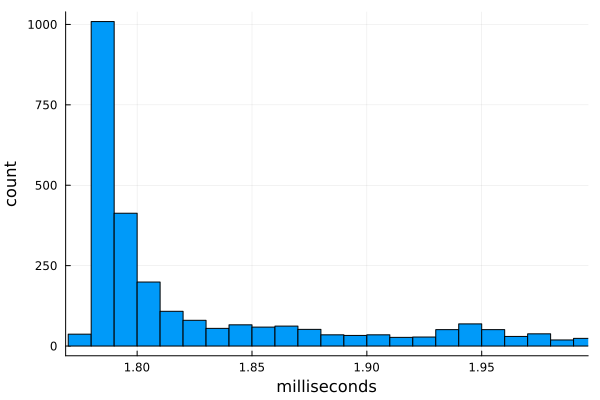

In [112]:
using Statistics

t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. Python's built in `sum`

The `PyCall` package provides a Julia interface to Python:

In [113]:
#]add PyCall

In [114]:
using PyCall

In [115]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [116]:
pysum(a)

5.000548102540173e6

In [117]:
pysum(a) ≈ sum(a)

true

In [118]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 4 samples with 1 evaluation.
 Range (min … max):  517.169 ms … 4.321 s  ┊ GC (min … max):  0.00% … 33.80%
 Time  (median):     554.461 ms            ┊ GC (median):     0.00%
 Time  (mean ± σ):      1.487 s ± 1.890 s  ┊ GC (mean ± σ):  24.56% ± 16.90%

  █                                                           
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  517 ms         Histogram: frequency by time         4.32 s <

 Memory estimate: 152.60 MiB, allocs estimate: 10000042.

In [119]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 2 entries:
  "C"               => 1.77887
  "Python built-in" => 517.169

# 3. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [120]:
using Pkg

In [121]:
Pkg.add("Conda")

   Resolving package versions...
  No Changes to `~/.julia/dev/Training/Project.toml`
  No Changes to `~/.julia/dev/Training/Manifest.toml`


In [122]:
using Conda 
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/joshday/.julia/packages/Conda/x2UxR/src/Conda.jl:127


Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done


In [123]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

LoadError: PyError (PyImport_ImportModule

The Python package numpy could not be imported by pyimport. Usually this means
that you did not install numpy in the Python version being used by PyCall.

PyCall is currently configured to use the Python version at:

/Applications/Xcode.app/Contents/Developer/usr/bin/python3

and you should use whatever mechanism you usually use (apt-get, pip, conda,
etcetera) to install the Python package containing the numpy module.

One alternative is to re-configure PyCall to use a different Python
version on your system: set ENV["PYTHON"] to the path/name of the python
executable you want to use, run Pkg.build("PyCall"), and re-launch Julia.

Another alternative is to configure PyCall to use a Julia-specific Python
distribution via the Conda.jl package (which installs a private Anaconda
Python distribution), which has the advantage that packages can be installed
and kept up-to-date via Julia.  As explained in the PyCall documentation,
set ENV["PYTHON"]="", run Pkg.build("PyCall"), and re-launch Julia. Then,
To install the numpy module, you can use `pyimport_conda("numpy", PKG)`,
where PKG is the Anaconda package that contains the module numpy,
or alternatively you can use the Conda package directly (via
`using Conda` followed by `Conda.add` etcetera).

) <class 'ModuleNotFoundError'>
ModuleNotFoundError("No module named 'numpy'")


In [124]:
numpy_sum(a) 

LoadError: UndefVarError: numpy_sum not defined

In [125]:
numpy_sum(a) ≈ sum(a)

LoadError: UndefVarError: numpy_sum not defined

In [126]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

LoadError: UndefVarError: py_numpy_bench not defined

# 4. Python, hand-written

In [127]:
py"""
def py_sum(a):
    s = 0.0
    for x in a:
        s = s + x
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x19bdb08b0>

In [ ]:
py_hand = @benchmark $sum_py($a)

In [ ]:
sum_py(a)

In [ ]:
sum_py(a) ≈ sum(a)

In [ ]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

# 5. Julia (built-in) 

## Written directly in Julia, not in C!

In [ ]:
@which sum(a)

In [ ]:
j_bench = @benchmark sum($a)

In [ ]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

# 6. Julia (hand-written)

In [ ]:
function mysum(A)   
    s = 0.0  # s = zero(eltype(A))
    #@inbounds @simd for a in A
    for a in A
        s += a
    end
    s
end

In [ ]:
j_bench_hand = @benchmark mysum($a)

In [ ]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

 # 7. Julia hand-written ++

In [ ]:
function myfastsum(A)   
    s = 0.0  # s = zero(eltype(A))
    @inbounds @simd for a in A  # <-- don't check bounds, parallel on processor
        s += a
    end
    s
end

In [ ]:
j_bench_hand_pp = @benchmark myfastsum($a)

In [ ]:
d["Julia hand-written-pp"] = minimum(j_bench_hand_pp.times) / 1e6
d

# Summary

In [ ]:
for (key, value) in sort(collect(d))
    println(rpad(key, 20, "."), lpad(round(value, digits=1), 8, "."))
end

In [ ]:
for (key, value) in sort(collect(d), by=x->x[2])
    println(rpad(key, 20, "."), lpad(round(value, digits=2), 10, "."))
end

In [ ]:
n=10000
a = [rand(1,3) for i=1:n]
b = [rand(3) for i=1:n]
dist(x,y) = norm(x-y)
@time dist.(a',b)

In [ ]:
using LinearAlgebra